## Active Learning: Simple illustration of the principles

In this exercise you will see the benefits of using active learning using a simple example. 

Consider the setting where some data denoted $D$ is observed on the line $[0,1]$ with a corresponding label being either $0$ or $1$. The labels are determined by an unknown threshold where all the observations with values below this threshold are given the label $0$ and all values above this threshold are given the label $1$. This problem is also known as the "high-low" game.

We make the following assumptions: 

1. We can obtain a noiseless label for a given observation, i.e. that each given observation is correctly labeled;
2. Obtaining a label is demanding hence limiting us on how many observations that we query a label for. 


So our task is to determine which of the available or easily obtainable observations we should query, i.e. get a label, in order to letting some given learner improve as much as possible.

For this simple setting we will use a margin classifier which simply estimates the decision boundary to be the threshold with the largest margin to both groups, i.e.:

$$T_{est} = max(X_0)+\frac{max(X_0)-min(X_1)}{2}$$

Where $X_k = \{x \mid x \in D, label(x) = k \}$ indicates the set of points with label $k$.


This problem is illustrated below with an increasing number of <font color=red>red points</font> and <font color=blue>blue points</font> being observations from the two different classes and the <font color=green>green dashed vertical line</font> is the unknown true threshold. The <font color=#ffe933>yellow dashed line</font> is the estimated threshold of our learner given the data.

Notice that in this particular case, in the final drawing the additional data points do not improve the learner. Obviously if you sample infinite points, the learner should improve.

<font color=blue> Task:
1. How do you classify the following problem setting using the scenario you have learned in the lecture?



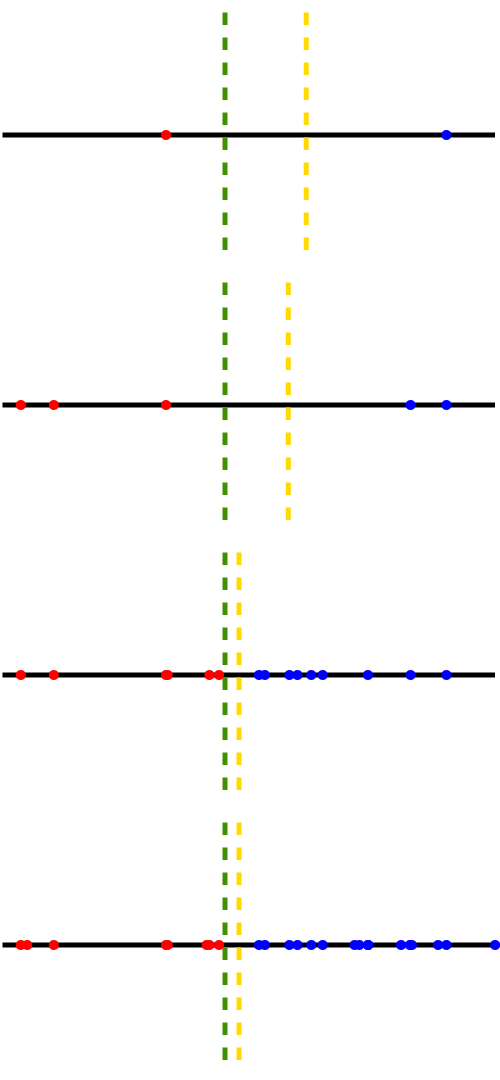

## Implementing the experiment

In order to implement this experiment we need to choose an interval and an acceptable uncertainty (margin) between the two groups. These can be set in the following code cell. Notice that we are assuming the `lower_bound` to be set to 0.

In [1]:
# Parameter to control the width of the 1-d feature space in the interval [0, T_MAX] that we consider
# Use lower values to keep the runtime of the following experiments reasonable (Default=5)
T_MAX=1
lower_bound = 0

# Parameter to control the largest accepted uncertainty of the threshold
TOL=1e-2

Below is some helper code for the following exercises. 

**NOTICE**: Every time you evaluate this code cell a new value for the threshold is generated. 

You can read it, but it is not necessary to understand the following sections. You just need to know that some help function are already implemented and available for you to use. Useful functions for the following exercises are:

1. `oracle`: takes an array of poiint and returns the binary label assigned to each of the points;

2. `get_bounds`: given an array of points and the respective labels, returns the boundaries of the two group, i.e. the boundary points of the space between the larger sample of label 0 and the smaller sample of label 1.

***HEJ PHILLIP***

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
import inspect

def print_threshold():
    """ Function to output the current threshold used by the blackbox oracle """
    print(inspect.signature(oracle)._parameters['threshold']._default)

def oracle(points, threshold=np.random.rand(1)*T_MAX*0.7+0.3*T_MAX, return_all=False):
    """ Oracle function taking an array of points and returning their corresponding labels """
    
    labels = (points>threshold).astype(bool)
    dist_min = np.min(np.abs(points-threshold))
    near_threshold = np.isclose(dist_min, 0, atol=1e-3) 
    if return_all:
        return labels, dist_min, near_threshold
    else:
        return labels

def plot_line(points, ax=None, title=None, mark_new_point=True):
    """ Plot function for the problem at hand
    
         Able to update an existing figure
    """
    ax = plt.gca() if not ax else ax
    y=np.zeros(points.shape)
    labels, dist_min, _ = oracle(points, return_all=True)
    ax.clear()
    ax.set_xlim([0, T_MAX])
    ax.scatter(points[labels], y[labels],marker='x',s=50,color='b')
    ax.scatter(points[np.logical_not(labels)], y[np.logical_not(labels)],marker='x',s=50,color='r')
    
    if mark_new_point:
        ax.scatter(points[-1], y[-1],marker='d',s=100,color='b' if labels[-1] else 'r')
        
    title = 'dist to threshold = {}'.format(dist_min) if not title else title
    ax.set_title(title)
    fig.canvas.draw()
    

def get_bounds(points,labels):
    """ Function to get the current boundaries of the two groups
    """
    try:
        lower_bound=points[~labels][np.argmax(points[~labels])]
    except ValueError:
        lower_bound=0

    try:
        upper_bound=points[labels][np.argmin(points[labels])]
    except ValueError:
        upper_bound=T_MAX
    
    return lower_bound, upper_bound

def close_enough(points,labels):
    """ Function to determine if the learner has reached the accepted uncertainty
    """
    upper_bound, lower_bound = get_bounds(points, labels)
    
    dist = upper_bound-lower_bound
    est_threshold =np.min([upper_bound,lower_bound])+abs(dist)/2
    close_enough_dist=np.isclose(dist,0, atol=TOL, rtol=0)
    return close_enough_dist, dist, est_threshold

def run_experiment(points, learner):  
    n=0
    dists=[]
    near_threshold=False
    while not near_threshold:
        n+=1
        
        previous_points=np.copy(points)
        
        # Sample a random point on the interval
        new_point=learner(points)
        points=np.append(points,new_point)
        
        if set(previous_points) == set(points):
            print('No new points added. Stopping.')
            break

        labels, dist_min, _= oracle(points, return_all=True)
        dists.append(dist_min)

        near_threshold, dist_labels, est_threshold=close_enough(points,labels)

        title='dist between labels: {}'.format(abs(dist_labels))
        plot_line(points,ax=plt.gca(),title=title)
        time.sleep(0.01)
        
        

    print(f'Estimated threshold to be {est_threshold} using {n} samples')

In [3]:
print_threshold()

[0.99279042]


## A (Super) Naive Learner

The first "learner" that you can think of, even if it's not really a learner, it is one that randomly queries points in our range of interest (that is completely random sampling). As you may already have noticed, this is a really naive learner, that will not perform well in any practical application. 

<font color=blue> Task:
1. Implement the naive learner that queries a random data point in the line defined by $[0, T_{MAX}]$. **WARNING** Notice that the function that you have to implement is getting the points as input parameters, but in this case, since it is naive, it is not going to use any additional information it can get from those.
    
<font color=blue> 2. Even if the previous was a really "silly" learner, you can already improve it a bit by a trivial modification where you at least don't sample uninformative points Then, run the experiment with this new learner, which is still very naive, but at least it uses a bit of information it gets from the sampled points. **HINT**: in the silly learner, everytime we are sampling from the whole input space, you can already restrict the space of interest using informations from the sampled points. Have a look at the functions that are already implemented in the above code cell (like  `oracle` and `get_bounds`, because they will be useful. 


Estimated threshold to be 0.9953609650193718 using 4 samples


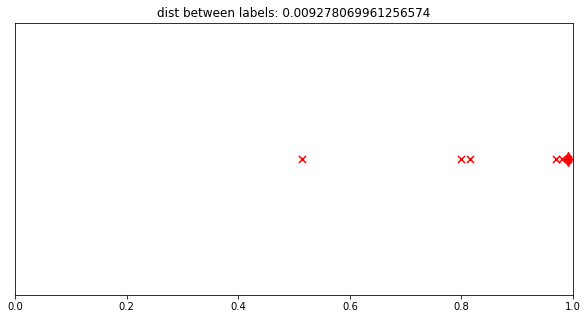

In [4]:

# Simulate two observations on the line in the interval [0, T_MAX]
points=np.random.rand(2)*T_MAX

fig=plt.figure(figsize=(10,5))
plot_line(points,  mark_new_point=False)
plt.gca().get_yaxis().set_visible(False)

# Stop to show two initial data points
input("First two points. Press Enter to continue sampling...")


### really silly learner
def naive_learner(points):
    # INSERT CODE HERE: the current function is always
    # returning the same point, 
    #change this function to return a 
    # random data point along the line defined by
    # the interval [0, T_MAX]
    
    lower_bound = 0
    upper_bound = T_MAX

    return np.random.uniform(lower_bound, upper_bound, 1) ## or np.random.rand(1)*(upper_bound-lower_bound)+lower_bound



### less but still silly learner
def naive_learner_v2(points):
    
    labels = oracle(points)
    lower_bound, upper_bound = get_bounds(points, labels)    
    
    return np.random.uniform(lower_bound, upper_bound, 1)
    
run_experiment(points, naive_learner_v2)


## A Smarter Learner

The last learner you implemented, was already using the information given by the previous sample, restricting the space of interest where we want to search. However, picking new data points randomly is not always very efficient. Can you do better?

<font color=blue> Task:
1. Think and implement the optimal learner (considering uncertainty sampling) for finding the threshold in a binary case.


Estimated threshold to be 0.995764522328902 using 4 samples


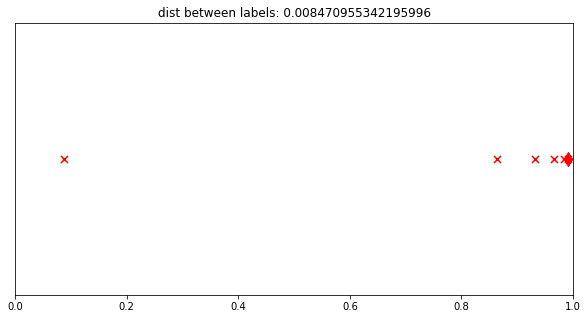

In [5]:

# Simulate two observations on the line in the interval [0, T_MAX]
points=np.random.rand(2)*T_MAX

fig=plt.figure(figsize=(10,5))
plot_line(points,  mark_new_point=False)
plt.gca().get_yaxis().set_visible(False)

input("First two points. Press Enter to continue sampling...")

# Smart learner
def smart_learner(points):

    labels = oracle(points)
    lower_bound, upper_bound = get_bounds(points, labels)

    threshhold_est = lower_bound+(upper_bound-lower_bound)/2
    
    return threshhold_est

run_experiment(points, smart_learner)

# Repeat the exercise in a setting where the oracle might lie
The oracle function is implemented below, with a given probability of $p_{lie}<0.5$ the oracle will return the wrong label

<font color=blue>1. Implement a Bayesian learner model which here update a posterior of the threshold. This is initially flat. Then each time a sample with a (noisy) label comes in it has to update the posterior. Note that normalization of the posterior can simply be done by normalizing the distribution such that is sums to one.</font>

<font color=blue>2. Use uncertainty sampling to determine the least confident point</font>

<font color=blue>3. Implement this in a learning where each time the least confident point is sampled</font>

<font color=blue>4. Investigate the behavior across different values of $p_{lie}$</font>


In [6]:
import numpy as np
threshold=np.random.rand(1)

In [7]:
import numba #numba is used to jit compilation making the otherwise very suboptimial implementation less of a problem
#it will still work without but likely ~5x more slowly
import matplotlib.pyplot as plt

plie = 0.1
#@numba.njit #you can remove this if needed
def oracle(x):
    lie = np.random.rand(1)<plie
    if x > threshold:
        label = True
    else:
        label= False
    if lie:
        return not label
    else:
        return label

x = np.linspace(0,1,500) #just a discretization of the space (candidate points)
pm = np.ones(len(x))/len(x) #initial model - we dont know the treshold so uniform

#here jit compilation is used to speed this up
#but feel free to remove this if you have problems - this part will still run in seconds
#@numba.njit
def updatemodel(point,label,pm):
    #calculate the updated model (pm)
    
    if label:
        pm[x > point] *= plie
        pm[x <= point] *= 1-plie
    else:
        pm[x < point] *= plie
        pm[x >= point] *= 1-plie
        
    pm /= sum(pm)
    
    return pm


N=10
it=0
for i in range(N):
    #for each of the candidate points,
    #calculate the probality of either class label and calculate
    #the least confidence measure for each of the candidate points
    p1 = np.cumsum(pm)
    p0 = 1-p1

    least_confident = 1 - np.max(np.column_stack((p0,p1)),axis=1)
    plt.figure()
    ax1 = plt.subplot(1,1,1)
    ax1.set_xlabel('x')
    ax1.set_ylabel('p(x)')
    ax1.plot(x,pm)
    ax2 = ax1.twinx()
    ax2.set_ylabel('least confident')
    ax2.plot(x,least_confident,'r:')
    #select the next point according to least confidence
    xs = x[np.argmax(least_confident)]
    #update the model with the new point
    pm = updatemodel(xs, oracle(xs),pm)
    it += 1
print('True theshold: %f,\nmaximum likelihood estimate of threshold: %f (%i iterations)'%(threshold,x[np.argmax(pm)],it))

# loop below is just doing the same as above without plotting to see if it converges after many interations
# mainly to see if the implementation is working as expected 
for i in range(400):
    p1 = np.cumsum(pm)
    p0 = 1-p1

    least_confident = 1 - np.max(np.column_stack((p0,p1)),axis=1)
    xs = x[np.argmax(least_confident)]
    pm = updatemodel(xs, oracle(xs), pm)
    it += 1

print('maximum likelihood estimate of threshold: %f (%i iterations)'%(x[np.argmax(pm)],it))

plt.figure()
ax1=plt.subplot(1,1,1)
ax1.set_xlabel('x')
ax1.set_ylabel('p(x)')
ax1.plot(x,pm)
ax2 = ax1.twinx()
ax2.set_ylabel('least confident')
ax2.plot(x,least_confident,'r:')
print('')

ModuleNotFoundError: No module named 'numba'

<font color=blue> <b>This is a more advanced exercise so do the second exercise of uncertainty sampling in the iris dataset first (exercise 6), then return to this exercise.
</b></font>
<br>
# Expected impact (here, expected entropy change)
Here we will extend the treatment above to implement expected impact equation (3.18) in the notes, however, it is not essential that you read this section yet, it will be quite logical - and might even help you a lot in understanding the notes once you implemented this.

Use the Bayesian estimator you implemented before, and implement a method to return the expected improvement in entropy by sampling additional points.
In the function expected_entropy_change we wish to calculate the change in entropy that would occur if we asked the oracle to label a point, note that we will not really as the oracle but just evaluate for both possible outcomes. We then just calculate the expectation by weighting according to how often our current model would expect to receive either label. If you think this is a lot of computation you are completely right we have to update the model a lot, which is also why this is seldomly done in practice.
An important key to understanding this is realising that the concept of model here is actually simply the probability distribution (<code>pm</code> in the code). Convince yourself that out current knowlegde is expressed in <code>pm</code> and consider what the model entropy means here. 

<font color=blue>
    <br>1. Implement the expected_entropy_change function
    <br>2. How does this relate to the expression for Kullback Leibler divergence ($\log(P(x)\log\frac{P(x)}{Q(x)}$), what is P and Q here?
    <br>3. Evaluate this expected change in entropy for some example cases and plot together with the uncertainty sampling estimate (code for plotting is provided)
    <br>4. Do the suggested sampling points tend to agree between uncertainty sampling and expected improvement?
    <br>5. Is this also the case when the label noise increase?
    <br>6. Can you explain this behavior?


In [ ]:
x = np.linspace(0,1,500) #just a discretization of the space
pm = np.ones(len(x))/len(x) #initial model - we dont know the treshold so uniform

# in the function below we wish to calculate the change in entropy that would occur if we asked the oracle about a point
#@numba.njit # again jit is not needed just substantially speeds up the code
def expected_entropy_change(pm):
    #for each potential x value assume that a sample with either label is received and update the model accordingly
    #current entropy
    H1 = ?
    H2 = np.zeros(2) # placeholder for updated entropy
    
    deltaEH=np.zeros(len(x))
    p_threshold_i=0. #probability that guess at this value will return true (above threshold)- initially 0
    for i,xi in enumerate(x):
        for j,label in enumerate((False,True)):
            #pretend to update model with new point, make sure to make a copy of pm (pm.copy()) to avoid actually changing the model
            pmnew= ?
            #updated entropy
            H2[j] = ?
        #update the probability of label p_threshold_i
        p_threshold_i += ?
        deltaEH[i] = ?
    return deltaEH

N=10
it=0
for i in range(N):
    EH=expected_entropy_change(pm)
    lc= ? # least confident sampling rule from previous exercise 
    #normalization to make it plotable in the same figure
    lc/=np.max(lc)
    lc*=np.max(EH)-np.min(EH)
    lc+=np.min(EH)
    plt.figure()
    ax1=plt.subplot(1,1,1)
    ax1.set_xlabel('x')
    ax1.set_ylabel('p(x)')
    ax1.plot(x,pm)
    ax2 = ax1.twinx()
    ax2.set_ylabel('Expected entropy change')
    ax2.plot(x,EH,'r:')
    

    ax2.plot(x,lc,'--g')
    ax2.plot(x[np.argmax(lc)],np.max(lc),'g*')
    xs=x[np.argmin(EH)]
    ax2.plot(xs,np.min(EH),'r*')
    pm=updatemodel(xs,oracle(xs),pm)
    it+=1
print('True theshold: %f,\nmaximum likelihood estimate of threshold: %f (%i iterations)'%(threshold,x[np.argmax(pm)],it))
import time
t0=time.time()
for i in range(400):
    EH=expected_entropy_change(pm)
    xs=x[np.argmin(EH)]
    pm=updatemodel(xs,oracle(xs),pm)
    it+=1
print(time.time()-t0)
print('maximum likelihood estimate of threshold: %f (%i iterations)'%(x[np.argmax(pm)],it))
plt.figure()
ax1=plt.subplot(1,1,1)
ax1.set_xlabel('x')
lc= ? # least confident sampling rule from before
#normalization to make it plotable in the same figure
lc/=np.max(lc)
lc*=np.max(EH)-np.min(EH)
lc+=np.min(EH)
ax2.plot(x,lc,'--g')
ax1.set_ylabel('p(x)')
ax1.plot(x,pm)
ax2 = ax1.twinx()
ax2.set_ylabel('Expected entropy change')
ax2.plot(x,EH,'r:')